<a href="https://colab.research.google.com/github/srigouri/CE888-Causal/blob/main/Jobs_Causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference on JOBS Dataset:

---

 Using Random Forest Regression for predictions and Random Forest classifier for classification to estimate causal effects in IHDP data.
 (Reference: CE888 Lab4 Task)

Loading Required Packages:

In [ ]:
!pip install econml


Importing Libraries:

In [ ]:
from econml.metalearners import XLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from causalfuncs import *

Loading Jobs data from https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv:

In [ ]:
jobs_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv')

Exploring JOBS data:

In [ ]:
jobs_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0


To check number of rows and columns in JOBS dataset:


In [ ]:
jobs_data.shape

JOBS data has got 20 columns in which columns with names x1 to x17 are input features,t denotes for treatment,y is the outcome,and e denotes Effect.The values for particular columns are extracted using integer-location based indexing and
assigning these values to the variables X,T,Yand e respectively.

In [ ]:
X=jobs_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17']]
T=jobs_data.iloc[:,17:18].values
Y=jobs_data.iloc[:,18:19].values
e=jobs_data.iloc[:,19:20].values

Data Pre-processing:
Splitting the Jobs data to Training, validation and testing data.First splitting complete dataset to Training and Testing data in 80/20 ratio.Then again splitting training data to Training and Validation data in 80/20 ratio.

In [ ]:
X_train, X_test, T_train, T_test, Y_train, Y_test,e_train,e_test = train_test_split(X, T, Y,e, test_size=0.2)
X_train, X_val,T_train,T_val,Y_train,Y_val,e_train,e_val = train_test_split(X_train,T_train,Y_train,e_train,test_size=0.20)

Checking the shapes of training,Validation,Testing Data


In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("T_train shape: {}".format(T_train.shape))
print("T_val shape: {}".format(T_val.shape))
print("T_test shape: {}".format(T_test.shape))
print("Y_train shape: {}".format(Y_train.shape))
print("Y_val shape: {}".format(Y_val.shape))
print("Y_test shape: {}".format(Y_test.shape))
print("e_train shape: {}".format(e_train.shape))
print("e_val shape: {}".format(e_val.shape))
print("e_test shape: {}".format(e_test.shape))

X_train shape: (2055, 17)
X_val shape: (514, 17)
X_test shape: (643, 17)
T_train shape: (2055, 1)
T_val shape: (514, 1)
T_test shape: (643, 1)
Y_train shape: (2055, 1)
Y_val shape: (514, 1)
Y_test shape: (643, 1)
e_train shape: (2055, 1)
e_val shape: (514, 1)
e_test shape: (643, 1)


(array([ 482.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2730.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

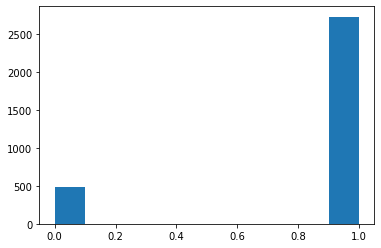

In [ ]:
plt.hist(Y)

(array([2915.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         297.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

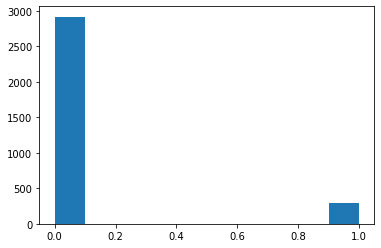

In [ ]:
plt.hist(T)

The above histograms of Y shows that the data is imbalanced.

Standardizing the input training data X. No standardization required for treatment variable T as the data is binary.

In [ ]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)

computing the means of effect in training,validation,test data

In [ ]:
np.mean(e_train),np.mean(e_val),np.mean(e_test)

Checking the shape of outcome variable:

In [ ]:
Y_train.shape

####Logistic Regression

Training The Model: Using four estimators for training the model:

Logistic Regression,Random forest regressor, Random forest with Inverse Propensity Weighting (IPW), X-learner with RF as base learners.

Concatenating X variable with 25 input features and T i.e treatment 
variable to train the model along with treatment.

Fitting Logistic Regressor on training data:


In [ ]:
lr = LogisticRegression()
XT_train = np.concatenate((X_train,T_train),axis=1)

lr.fit(XT_train, Y_train.ravel())

LogisticRegression()

For validation of model, y1_val and y0_val are predicted by setting treatment to 1 and 0 respectively.Treatment variable (T=0,T=1) is again merged accordingly with X data.Predicted outcomes for both treated and controlled for each individuals as y1_val,y0_val and obtained treatement effect using e= y1-y0.

In [ ]:
xt0_val = np.concatenate([X_val, np.zeros_like(T_val)], axis=1)
lr_y0_val = lr.predict(xt0_val)

xt1_val = np.concatenate([X_val, np.ones_like(T_val)], axis=1)
lr_y1_val = lr.predict(xt1_val)

lr_te_val = lr_y1_val - lr_y0_val
np.mean(lr_te_val)

Predictions using Test data:

y1_test and y0_test are predicted by setting treatment to 1 and 0 respectively.
Setting T to a 1 and 0 for all individuals using zeros_like and one_like and merge with X_test to obtain effect estimates.
Outcomes for both treated and controlled for each individuals as y1_test,y0_test and obtained effect using e=y1-y0

In [ ]:
xt0_test = np.concatenate([X_test, np.zeros_like(T_test)], axis=1)
lr_y0_test = lr.predict(xt0_test)

xt1_test = np.concatenate([X_test, np.ones_like(T_test)], axis=1)
lr_y1_test = lr.predict(xt1_test)

lr_te_test = lr_y1_test - lr_y0_test
np.mean(lr_te_test)

#### Random Forest Regression
Fitting Random Forest Regressor on training data:


In [ ]:
rf = RandomForestRegressor()
rf.fit(XT_train, Y_train.flatten())

RandomForestRegressor()

Using Random Forest Regression model,validating outcomes for both treated and controlled for each individuals as y1_val,y0_val and obtained treatement effect using e= y1-y0.

In [ ]:
xt0_val = np.concatenate([X_val, np.zeros_like(T_val)], axis=1)
rf_y0_val = rf.predict(xt0_val)

xt1_val = np.concatenate([X_val, np.ones_like(T_val)], axis=1)
rf_y1_val = rf.predict(xt1_val)

rf_e_val = rf_y1_val - rf_y0_val
np.mean(rf_e_val)

In [ ]:
xt0_test = np.concatenate([X_test, np.zeros_like(T_test)], axis=1)
rf_y0_test = rf.predict(xt0_test)

xt1_test = np.concatenate([X_test, np.ones_like(T_test)], axis=1)
rf_y1_test = rf.predict(xt1_test)

rf_e_test = rf_y1_test - rf_y0_test
np.mean(rf_e_test)

####RandomForestClassifier with Inverse Propensity Score(IPW):

Training using RandomForestClassifier extending with with the Inverse Propensity Weighting (IPW),to model unit's probability of receiving the treatment, P(ti|xi). This is a classic binary classification problem using input X,treatment T. P(ti|xi)  is called a propensity score.

To get the sample weights, get_ps_weights function is called from causalfuncs.py which is available at https://github.com/srigouri/CE888-Causal/blob/main/causalfuncs.py

In [ ]:
from causalfuncs import get_ps_weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, X_train, T_train)

rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(XT_train, Y_train.flatten(), sample_weight=weights)

RandomForestRegressor()

In [ ]:
rf_ipsw_y0_test =rf_ipsw.predict(xt0_test) 
rf_ipsw_y1_test =rf_ipsw.predict(xt1_test) 

rf_ipsw_te_test = rf_ipsw_y1_test - rf_ipsw_y0_test 
np.mean(rf_ipsw_te_test)

Hyper-parameter Tuning:

Using GridSearch and RandomForest Classifier.

In [ ]:
params = {'max_depth': [1, 2, 5, 10, 20, None], 'max_leaf_nodes': [2, 5, 10, 20, 30, None]}
gs = GridSearchCV(prop_clf, params, cv=10)

gs.fit(XT_train,Y_train)
gs.best_params_


NameError: ignored

In [ ]:
gs.best_score_


In [ ]:
y_pred_test = gs.predict(X_test)

gs_report = classification_report(y_test, y_pred_test)
print(gs_report)

gs_conf_mat = confusion_matrix(y_test, y_pred_test, labels=gs.classes_, normalize='all')
disp = ConfusionMatrixDisplay(gs_conf_mat, display_labels=gs.classes_)
disp.plot()